In [1]:
import time
start_notebook_time = time.time()

In [2]:
import sklearn.linear_model
from sklearn.datasets import fetch_openml
import sys
import numpy as np
# np.set_printoptions(threshold=sys.maxsize)

In [3]:
mnist = fetch_openml('mnist_784', version=1)

/Users/zivlazarov/miniforge3/envs/tensorflow-env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
X.iloc[0, -3:-1]

pixel782    0.0
pixel783    0.0
Name: 0, dtype: float64

In [7]:
# setting pixel values to be in [0, 1] range
# X = X/255.0

In [8]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# getting the correct shape
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

In [11]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [12]:
# working with integers instead of strings for convenience
y = y.apply(lambda x : int(x))

In [13]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [14]:
X, y = X.to_numpy(), y.to_numpy()

In [15]:
import matplotlib.pyplot as plt

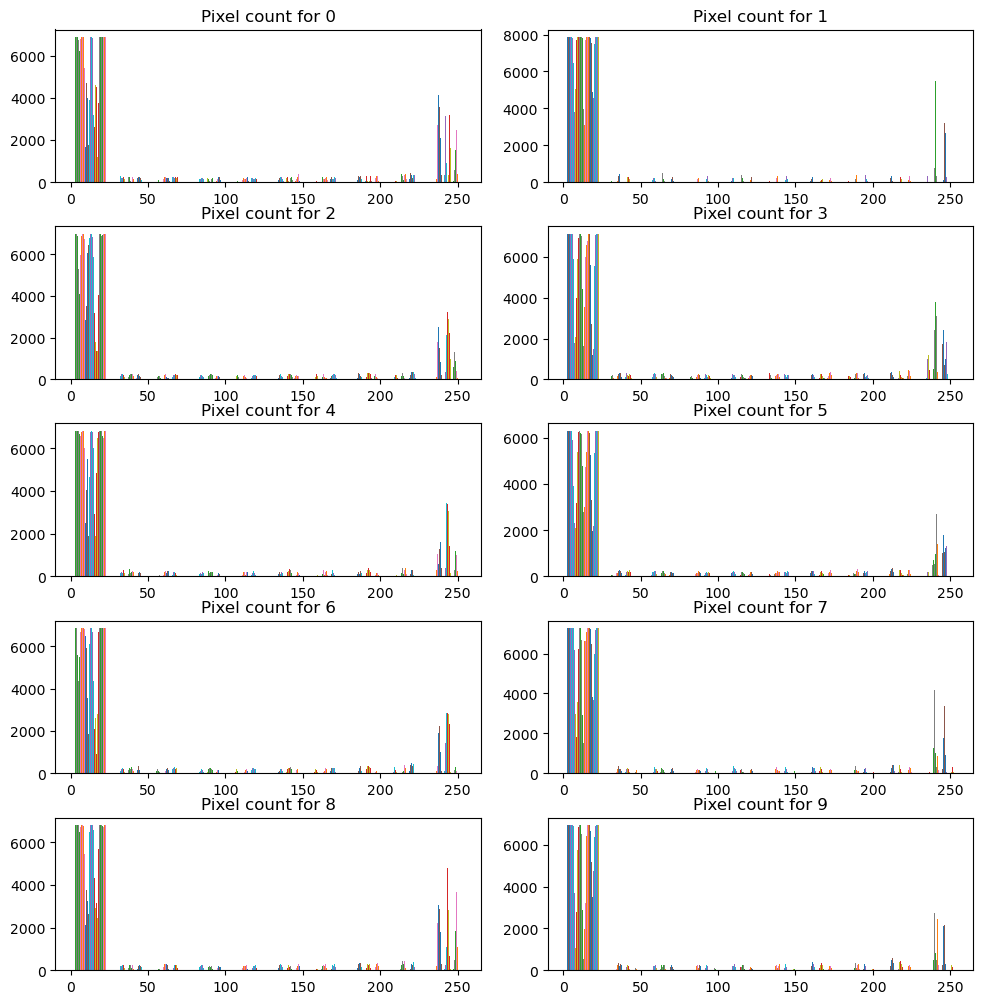

In [16]:
# showing distribution of pixels for every digit
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout()
for i in range(len(np.unique(y))):
    # not taking the bias column into consideration
    ax[i//2, i%2].hist(X[np.where(y == i)][:, 1:])
    ax[i//2, i%2].set_title(f'Pixel count for {i}')

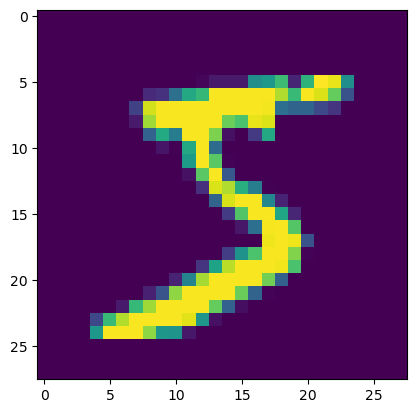

In [17]:
# getting an idea of an image
plt.imshow(X[0, :].reshape(28, 28))

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

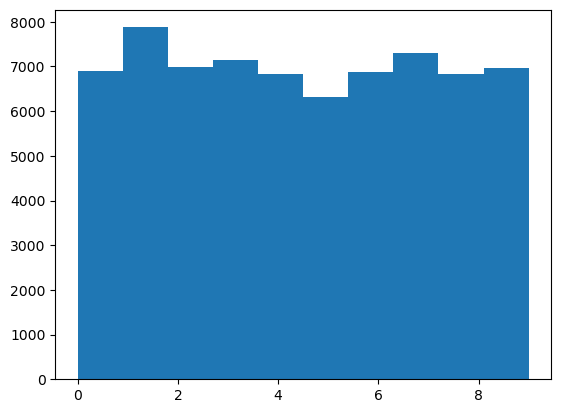

In [18]:
# check distribution of each digit
plt.hist(y)

In [19]:
# adding the bias column as the first column
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis=1)

In [20]:
np.unique(X[:, 0])

array([1.])

In [21]:
X.shape

(70000, 785)

In [22]:
class Perceptron:

    def __init__(self, num_features, classes, epochs=1):
        # num_features includes the extra bias column with the dataset so we'll add it
        self.num_features = num_features
        # values of the multi-class labels
        self.classes = classes
        self.num_classes = len(self.classes)
        self.num_samples = 0
        self.epochs = epochs
        
        # initializing the weights vectors for every class with values [-1, 1]
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_classes, self.num_features))
        # weight vectors for pocketing
        self.final_weights = None
        # determined by the size of samples
        self.labels = None
                  
    def init_multi_class_labels(self, y_train, negative_value=-1):
        self.num_samples = y_train.shape[0]
        # initializing the perceptron training labels
        self.labels = np.ones(shape=(self.num_classes, self.num_samples))
        # setting labels' values based on every class in the training data
        for class_idx in range(self.num_classes):
            self.labels[class_idx, np.where(y_train != class_idx)[0]] = negative_value

    def fit(self, X_train, y_train, visualize=True):
        self.init_multi_class_labels(y_train)
        # defining error value for each class for pocket algorithm
        min_errors = np.full(shape=(self.num_classes,), fill_value=np.inf)
        
        '''
        choosing 16% (arbitrary decision) of the dataset as random samples to calculate errors,
        as we can see from the above cells, the number of occurrences of each digit is 
        distributed almost uniformly, so getting 16% of the samples can distribute the amount of each
        digit in the random sample almost evenly for more general optimization
        '''
        num_random_samples = int(0.16 * self.num_samples)
        # initializing the final_weights here for easier usage with inheritance
        self.final_weights = np.copy(self.weights)
        visualization_iteration_skip = 10
        # error values for every 10th iteration (/sample) for the visualization
        iterations_errors = np.full(shape=(self.num_samples//visualization_iteration_skip, self.num_classes), fill_value=np.inf)
        # traversing the dataset (per sample approach)
        for epoch in range(self.epochs):
            for t in range(self.num_samples):
                # predicting the current sample with every weight vector using the np.sign method
                # because probability of the dot product to be exactly 0 is very low, and if so, we'll count predictions on the hyperplane
                # to be negative
                y_preds = np.sign(self.weights.dot(X_train[t]))

                # dividing classes based on their predictions
                misclassified_classes_indexes = np.where(y_preds != self.labels[:, t])
                # correcting misclassified weight vectors by multiplying the true sign value by the current sample for each weight vector
                self.weights[misclassified_classes_indexes] += \
                    self.labels[misclassified_classes_indexes, t][0][:, np.newaxis] * X_train[t, :]
                    
                # pocketing every 10 samples
                if t % visualization_iteration_skip == 0:
                    # getting random indexes for the sampling
                    random_samples_indexes = np.random.choice(self.num_samples, num_random_samples)

                    # calculating the errors from the random samples based on the improved vectors
                    y_preds_unsigned = self.weights.dot(X_train[random_samples_indexes, :].T)
                    errors_t = np.sum(
                        np.sign(y_preds_unsigned) != self.labels[:, random_samples_indexes],
                        axis=1) / num_random_samples

                    if visualize:
                        iterations_errors[t//visualization_iteration_skip] = np.copy(errors_t)

                    # pocketing the improved weight vectors and updating the min errors
                    to_improve_classes_indexes = np.where(errors_t < min_errors)[0]
                    
                    self.final_weights[to_improve_classes_indexes] = \
                        np.copy(self.weights[to_improve_classes_indexes])
                    
                    min_errors[to_improve_classes_indexes] = errors_t[to_improve_classes_indexes]
                    
        # visualizing the errors for each class
        if visualize:
            fig, ax = plt.subplots(self.num_classes//2, 2, figsize=(10, 10))
            fig.tight_layout()
            x_axis = [epoch*visualization_iteration_skip for epoch in range(iterations_errors.shape[0])]
            for i in range(iterations_errors.shape[1]):
                ax[i//2, i%2].plot(x_axis, iterations_errors[:, i])
                ax[i//2, i%2].set_title(f'Error for class {i}')
            # setting the max value of the y axis to be 0.5 for better readability
            plt.setp(ax, xlim=(0, self.num_samples), ylim=(0, 0.5))
            plt.show()
        
        print(min_errors)
        # setting the trained weight vectors
        self.weights = np.copy(self.final_weights)
                        
    def predict(self, X_test):
        return np.argmax(X_test.dot(self.weights.T), axis=1)
    
    def accuracy(self, predictions, y_test):
        return np.sum(predictions == y_test) / len(y_test)

In [23]:
from sklearn.model_selection import train_test_split
num_train_samples = 60000

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train_samples/len(X), shuffle=True)

In [25]:
X_train.shape

(60000, 785)

In [26]:
perceptron = Perceptron(num_features=X_train.shape[1], classes=np.unique(y), epochs=1)

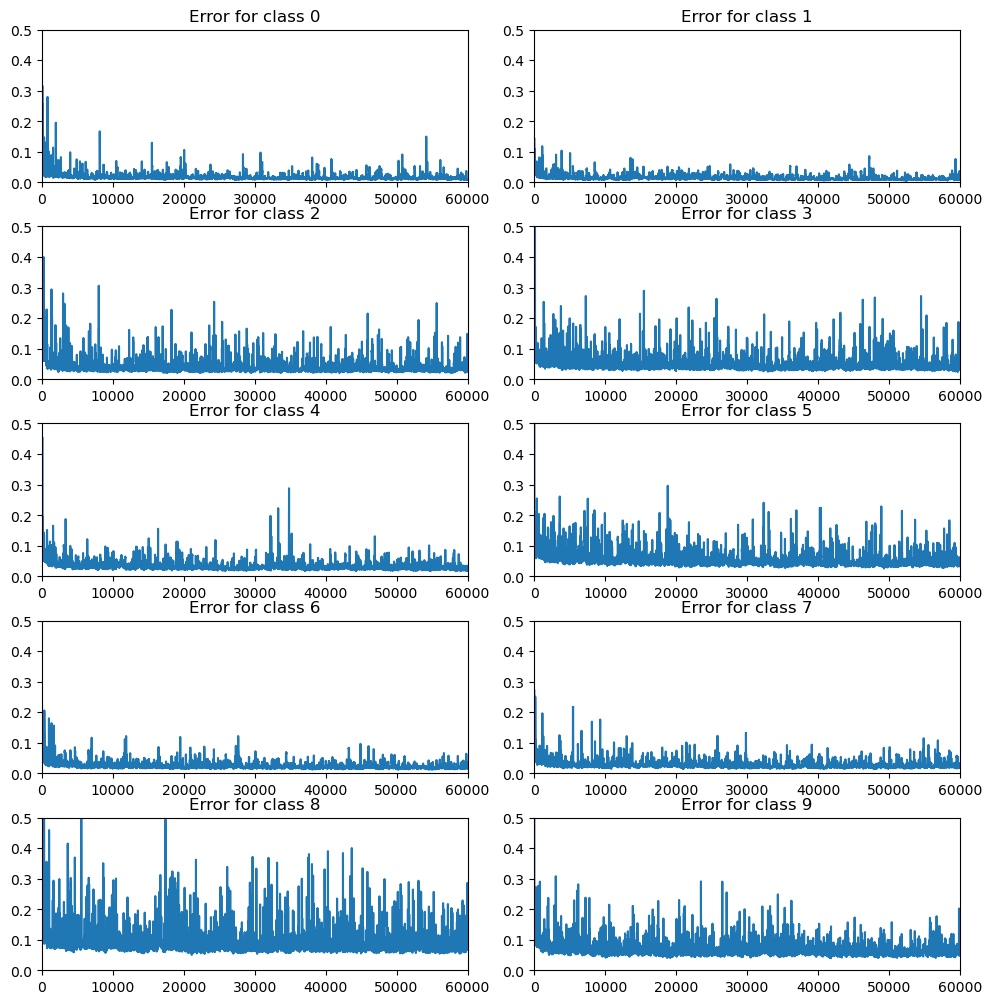

[0.00697917 0.00520833 0.02041667 0.02364583 0.016875   0.02583333
 0.0115625  0.01375    0.05020833 0.03947917]


In [27]:
start_time = time.time()
perceptron.fit(X_train, y_train)
end_time = time.time()

In [28]:
end_time - start_time

109.21052312850952

In [29]:
predictions = perceptron.predict(X_test)
predictions

array([5, 2, 9, ..., 1, 7, 1])

In [31]:
perceptron.accuracy(predictions, y_test)

0.8945

In [89]:
import seaborn as sns

def visualize_metrics(class_idx, X_test, y_test, perceptron):
    if class_idx == -1:
        predictions = perceptron.predict(X_test)
        confusion_matrix = np.zeros(shape=(perceptron.num_classes, perceptron.num_classes))
        for idx in range(len(y_test)):
            y_test_idx = y_test[idx]
            preds_idx = predictions[idx]
            confusion_matrix[y_test_idx, preds_idx] += 1
        sns.heatmap(confusion_matrix, annot=True, fmt='.4g')
        plt.ylabel('Y True')
        plt.xlabel('Y Pred')
        plt.title(f'Multi Class Perceptron Confusion Matrix\nAccuracy: {round(np.sum(predictions == y_test) / len(y_test), 2)}')
        plt.show()
    else:
        # creating the grid for the classes
        fig, ax = plt.subplots(perceptron.num_classes//2, 2, figsize=(10, 10), constrained_layout=True)
        # fig.tight_layout()
        for i in range(perceptron.num_classes):
            class_sign_y = np.ones(shape=(len(y_test), ))
            class_sign_y[np.where(y_test != perceptron.classes[i])] = -1

            predictions = np.sign(X_test.dot(perceptron.weights[i]))
            
            # predicted class_idx correctly
            tp = len(class_sign_y[(class_sign_y == predictions) & (class_sign_y == 1)])
            # predicted not class_idx correctly
            tn = len(class_sign_y[(class_sign_y == predictions) & (class_sign_y == -1)])
            # predicted class_idx incorrectly
            fp = len(class_sign_y[(class_sign_y != predictions) & (class_sign_y == -1)])
            # predicted not class_idx incorrectly
            fn = len(class_sign_y[(class_sign_y != predictions) & (class_sign_y == 1)])

            accuracy = (tp + tn) / len(y_test)
            sensitivity = tp / (tp + fn)
            selectivity = tn / (tn + fp)
            
            confusion_matrix = np.zeros(shape=(2, 2))
            confusion_matrix[0, 0] = tp
            confusion_matrix[0, 1] = fn
            confusion_matrix[1, 0] = fp
            confusion_matrix[1, 1] = tn
            
            sns.heatmap(confusion_matrix, ax=ax[i//2, i%2], annot=True, fmt='.4g')
            ax[i//2, i%2].set_title(f'Confusion Matrix for Class {perceptron.classes[i]}\n' + \
            f'Acc: {round(accuracy, 2)} | Sen: {round(sensitivity, 2)} | Sel: {round(selectivity, 2)}')
            ax[i//2, i%2].set_ylabel('Y True')
            ax[i//2, i%2].set_xlabel('Y Pred')
        plt.show()

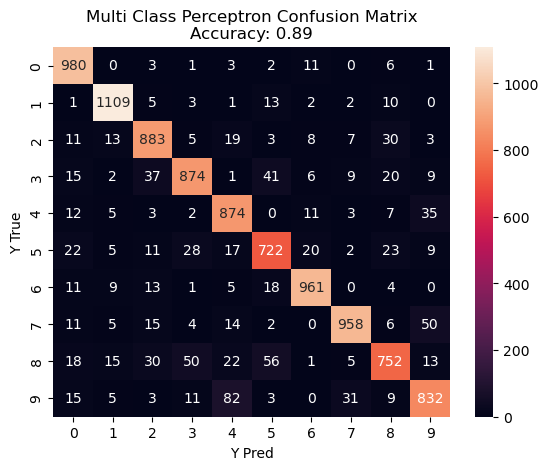

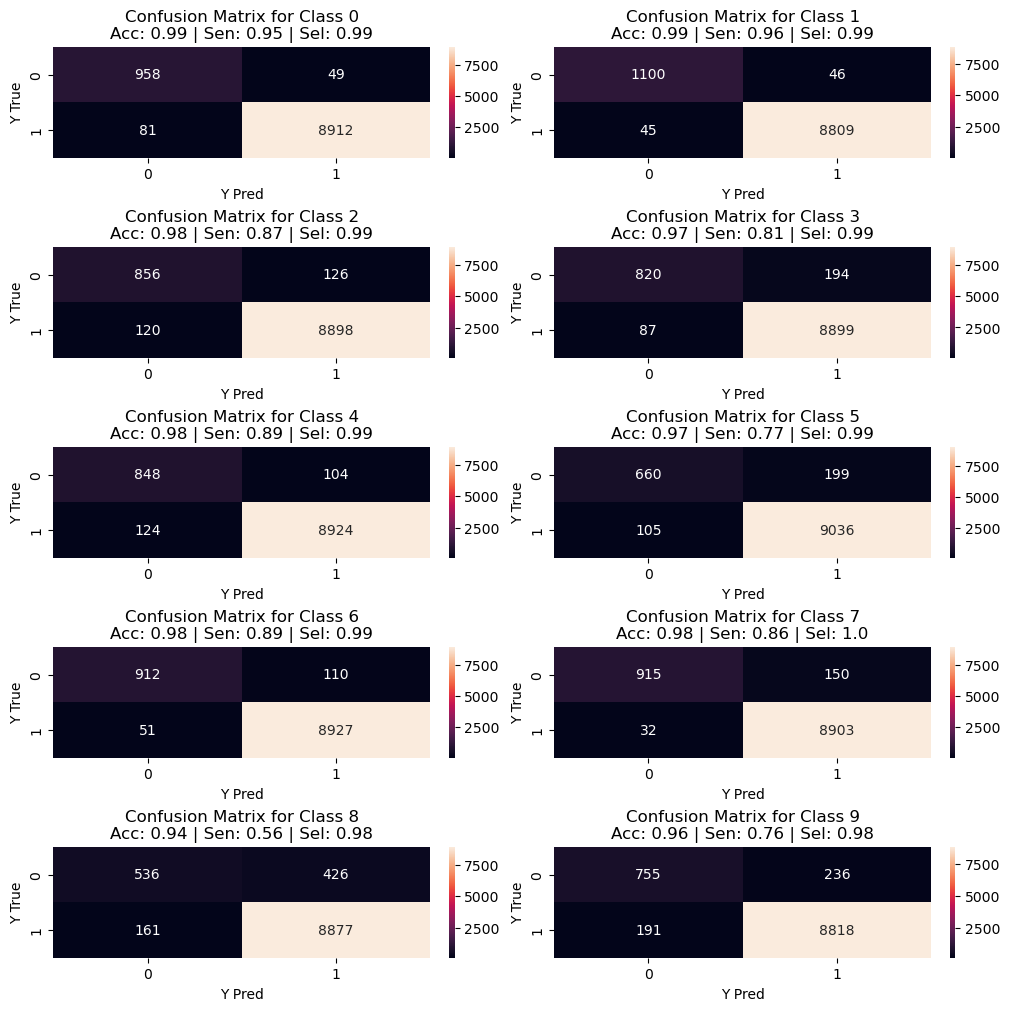

In [90]:
visualize_metrics(-1, X_test, y_test, perceptron)
visualize_metrics(0, X_test, y_test, perceptron)

In [35]:
'''
We can see from the metrics that out selectivity for each digit is very high, and our sensitivity is a little lower, which means our binary
classifiers are not classifying false positives in large quantities, and some are classifying false negatives more than they "should".
This gives us more confidence in the classifiers for not predicting positively incorrectly, but they will predict more negatives in such
matter.
In terms of accuracy, the binary classifiers are very accurate.
In respect to the multi class perceptron, we can see from the loss functions during training that 0,1,4,6,7 digits are more stable in terms
of the loss values, and somehow their loss values are converging towards 0, which the other digits are more noisy and are less
confident during training.
My assumption is that more strong pixel values in the samples are affecting this scenario, as 2,3,5,8,9 are digits which require more
pixels to show.
For the training itself, I went for the more efficient-focused implementation, using the fact that the digits in the dataset are 
distributed almost uniformly which makes it easy for us to random-sample the training data to calculate our loss function with
confidence as we can assume the samples will also distribute uniformly in the calculation. This approach led me to calculate the loss
function and pocket the relevant weights vectors accordingly every 10 iterations to save valuable time and resources during
training without sacrificing the correctness of the algorithm.
'''

'\nWe can see from the metrics that out selectivity for each digit is very high, and our sensitivity is a little lower, which means our binary\nclassifiers are not classifying false positives in large quantities, and some are classifying false negatives more than they "should".\nThis gives us more confidence in the classifiers for not predicting positively incorrectly, but they will predict more negatives in such\nmatter.\nIn terms of accuracy, the binary classifiers are very accurate.\nIn respect to the multi class perceptron, we can see from the loss functions during training that 0,1,4,6,7 digits are more stable in terms\nof the loss values, and somehow their loss values are converging towards 0, which the other digits are more noisy and are less\nconfident during training.\nMy assumption is that more strong pixel values in the samples are affecting this scenario, as 2,3,5,8,9 are digits which require more\npixels to show.\nFor the training itself, I went for the more efficient-focu

In [36]:
# standarizing the features' values
# X_train[:, 1:], X_test[:, 1:] = X_train[:, 1:] / 255.0, X_test[:, 1:] / 255.0

In [37]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(s):
    # normalize values to avoid over/underflow of the values (works if weight vectors aren't the zero vector)
    mean = np.mean(s, keepdims=True)
    std = np.std(s, keepdims=True)
    z = (s - mean) / std
    z = np.exp(z)
    return z / np.sum(z, axis=0)

# inheriting from the perceptron class to use the predict and metrics methods
class LogisticRegression(Perceptron):

    def __init__(self, num_features, classes, learning_rate=0.01, epochs=1):
        # initializing variables like the perceptron
        super().__init__(num_features=num_features, classes=classes, epochs=epochs)
        self.lr = learning_rate
        # weights vectors' components are still uniformly distributes between -1 and 1

    def fit(self, X_train, y_train):
        # setting the negative value to be zero for the indicator in the gradient calculation
        super().init_multi_class_labels(y_train=y_train, negative_value=0)

        # need gradients to be of shape (self.num_classes, self.num_features)
        # where gradients[i] = sum((softmax(w_i, x_n) - I[y_n = i]) * x_n)
        for epoch in range(self.epochs):
            # shape = (num_classes x num_samples)
            # row i refers to the exponent of w_i with all the samples
            weights_X_exp = self.weights @ X_train.T

            '''
            1. self.labels is the indicator in the gradient.
            2. multiplying every result (i.e softmax - indicator) by the matching sample
            needed to add a new dimension to multiply each result by the relevant sample for each of the weight vectors
            '''
            gradients = np.sum((softmax(weights_X_exp) - self.labels)[:, :, np.newaxis] * X_train, axis=1)
            
            # making the weight vectors to go in the opposite direction of the matching gradient self.lr "steps"
            self.weights -= self.lr * gradients

    def predict(self, X_test):
        return np.argmax(softmax(X_test @ self.weights.T), axis=1)
            

In [38]:
logistic_regression = LogisticRegression(X.shape[1], np.unique(y), epochs=50)

In [39]:
start_time = time.time()
logistic_regression.fit(X_train, y_train)
end_time = time.time()
end_time - start_time

53.692997217178345

In [40]:
predictions = logistic_regression.predict(X_test)

In [41]:
predictions

array([5, 2, 9, ..., 1, 9, 1])

In [42]:
logistic_regression.accuracy(predictions, y_test)

0.8446

In [43]:
time.time() - start_notebook_time

255.26964592933655